# 02 - Exploratory Data Analysis

Explore and validate scraped BaT data before modeling.

**Inputs:**
- `data/raw/bat_listings.parquet`

**Outputs:**
- `data/processed/cleaned_listings.parquet`

In [1]:
import logging
from pathlib import Path

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from price_analysis.data import clean_listings
from price_analysis.data.cleaning import get_summary_stats, prepare_model_data

logging.basicConfig(level=logging.INFO)
sns.set_theme(style="whitegrid")
plt.rcParams["figure.figsize"] = (12, 6)

In [2]:
# Paths
DATA_DIR = Path("../data")
RAW_PATH = DATA_DIR / "raw" / "bat_listings.parquet"
PROCESSED_DIR = DATA_DIR / "processed"
PROCESSED_DIR.mkdir(parents=True, exist_ok=True)
OUTPUT_PATH = PROCESSED_DIR / "cleaned_listings.parquet"

## Load Raw Data

In [3]:
df_raw = pd.read_parquet(RAW_PATH)
print(f"Raw data: {len(df_raw)} listings")
display(df_raw.head())

Raw data: 25 listings


,listing_url,title_raw,sale_price,sale_date,model_year,generation,trim,transmission,mileage,color,location
0,https://bringatrailer.com/listing/2019-porsche...,100-Mile Meissen Blue 2019 Porsche 911 Speedster,531000,2025-12-23,2019.0,991.2,None,Manual,100.0,-to-Sample Meissen Blue,"Novato, California 94949"
1,https://bringatrailer.com/listing/1974-porsche...,Twin-Turbocharged 3.0L-Powered 1974 Porsche 91...,77500,2025-12-23,NaN,None,None,Manual,47000.0,Silver,"Houston, Texas 77098"
2,https://bringatrailer.com/listing/2007-porsche...,2007 Porsche 911 Carrera Cabriolet,30000,2025-12-23,2007.0,997.1,Carrera,Automatic,51000.0,Basalt Black Metallic,"Big Spring, Texas 79720"
3,https://bringatrailer.com/listing/2003-porsche...,2003 Porsche 911 Carrera Cabriolet 6-Speed,19851,2025-12-23,2003.0,996.2,Carrera,Manual,85000.0,Arctic Silver Metallic,"Watertown, New York 13601"
4,https://bringatrailer.com/listing/1999-porsche...,LS3-Powered 1999 Porsche 911 Carrera 4 Coupe 6...,35911,2025-12-23,1999.0,996.1,Carrera 4,Manual,187000.0,Blue,"Fuquay Varina, North Carolina 27526-0138"


In [4]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25 entries, 0 to 24
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   listing_url   25 non-null     object        
 1   title_raw     25 non-null     object        
 2   sale_price    25 non-null     int64         
 3   sale_date     24 non-null     datetime64[ns]
 4   model_year    20 non-null     float64       
 5   generation    13 non-null     object        
 6   trim          21 non-null     object        
 7   transmission  23 non-null     object        
 8   mileage       22 non-null     float64       
 9   color         22 non-null     object        
 10  location      25 non-null     object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(7)
memory usage: 2.3+ KB


## Clean and Validate

In [5]:
df = clean_listings(df_raw, drop_invalid=False)
display(df.head())

INFO:price_analysis.data.cleaning:Cleaning 25 listings
ERROR:price_analysis.data.cleaning:Listing https://bringatrailer.com/listing/1974-porsche-911-cabiriolet-conversion/: ['Missing model_year']
ERROR:price_analysis.data.cleaning:Listing https://bringatrailer.com/listing/1976-porsche-930-turbo-carrera-31/: ['Missing model_year']
ERROR:price_analysis.data.cleaning:Listing https://bringatrailer.com/listing/wheels-352/: ['Missing model_year']
ERROR:price_analysis.data.cleaning:Listing https://bringatrailer.com/listing/transaxle-13/: ['Missing model_year']
ERROR:price_analysis.data.cleaning:Listing https://bringatrailer.com/listing/literature-45/: ['Missing model_year']
INFO:price_analysis.data.cleaning:Cleaning complete. Final dataset: 25 listings


,listing_url,title_raw,sale_price,sale_date,model_year,generation,trim,transmission,mileage,color,location,sale_year,age,mileage_10k,mileage_scaled,color_category,log_price,is_valid
0,https://bringatrailer.com/listing/2019-porsche...,100-Mile Meissen Blue 2019 Porsche 911 Speedster,531000,2025-12-23,2019,991.2,None,Manual,100,-to-Sample Meissen Blue,"Novato, California 94949",2025.0,6.0,0.01,-0.923777,standard,13.182517,True
1,https://bringatrailer.com/listing/1974-porsche...,Twin-Turbocharged 3.0L-Powered 1974 Porsche 91...,77500,2025-12-23,<NA>,None,None,Manual,47000,Silver,"Houston, Texas 77098",2025.0,<NA>,4.7,-0.212522,standard,11.258033,False
2,https://bringatrailer.com/listing/2007-porsche...,2007 Porsche 911 Carrera Cabriolet,30000,2025-12-23,2007,997.1,Carrera,Automatic,51000,Basalt Black Metallic,"Big Spring, Texas 79720",2025.0,18.0,5.1,-0.15186,standard,10.308953,True
3,https://bringatrailer.com/listing/2003-porsche...,2003 Porsche 911 Carrera Cabriolet 6-Speed,19851,2025-12-23,2003,996.2,Carrera,Manual,85000,Arctic Silver Metallic,"Watertown, New York 13601",2025.0,22.0,8.5,0.363762,standard,9.896010,True
4,https://bringatrailer.com/listing/1999-porsche...,LS3-Powered 1999 Porsche 911 Carrera 4 Coupe 6...,35911,2025-12-23,1999,996.1,Carrera 4,Manual,187000,Blue,"Fuquay Varina, North Carolina 27526-0138",2025.0,26.0,18.7,1.910629,standard,10.488799,True


In [6]:
stats = get_summary_stats(df)
print(f"Total listings: {stats['n_listings']}")
print(f"Valid listings: {stats['n_valid']}")
print(f"Date range: {stats['date_range'][0]} to {stats['date_range'][1]}")
print(f"Price range: ${stats['price_range'][0]:,} to ${stats['price_range'][1]:,}")
print(f"Median price: ${stats['price_median']:,}")
print(f"Median mileage: {stats['mileage_median']:,}")

Total listings: 25
Valid listings: 20
Date range: 2025-12-22 00:00:00 to 2025-12-25 00:00:00
Price range: $700 to $876,000
Median price: $69,000.0
Median mileage: 43,000.0


## Missing Data Report

In [7]:
missing = df.isna().sum()
missing_pct = (missing / len(df) * 100).round(1)
missing_report = pd.DataFrame({"missing": missing, "pct": missing_pct})
display(missing_report[missing_report["missing"] > 0].sort_values("missing", ascending=False))

,missing,pct
generation,12,48.0
age,6,24.0
model_year,5,20.0
trim,4,16.0
mileage,3,12.0
color,3,12.0
mileage_10k,3,12.0
mileage_scaled,3,12.0
transmission,2,8.0
sale_date,1,4.0


## Distribution Plots

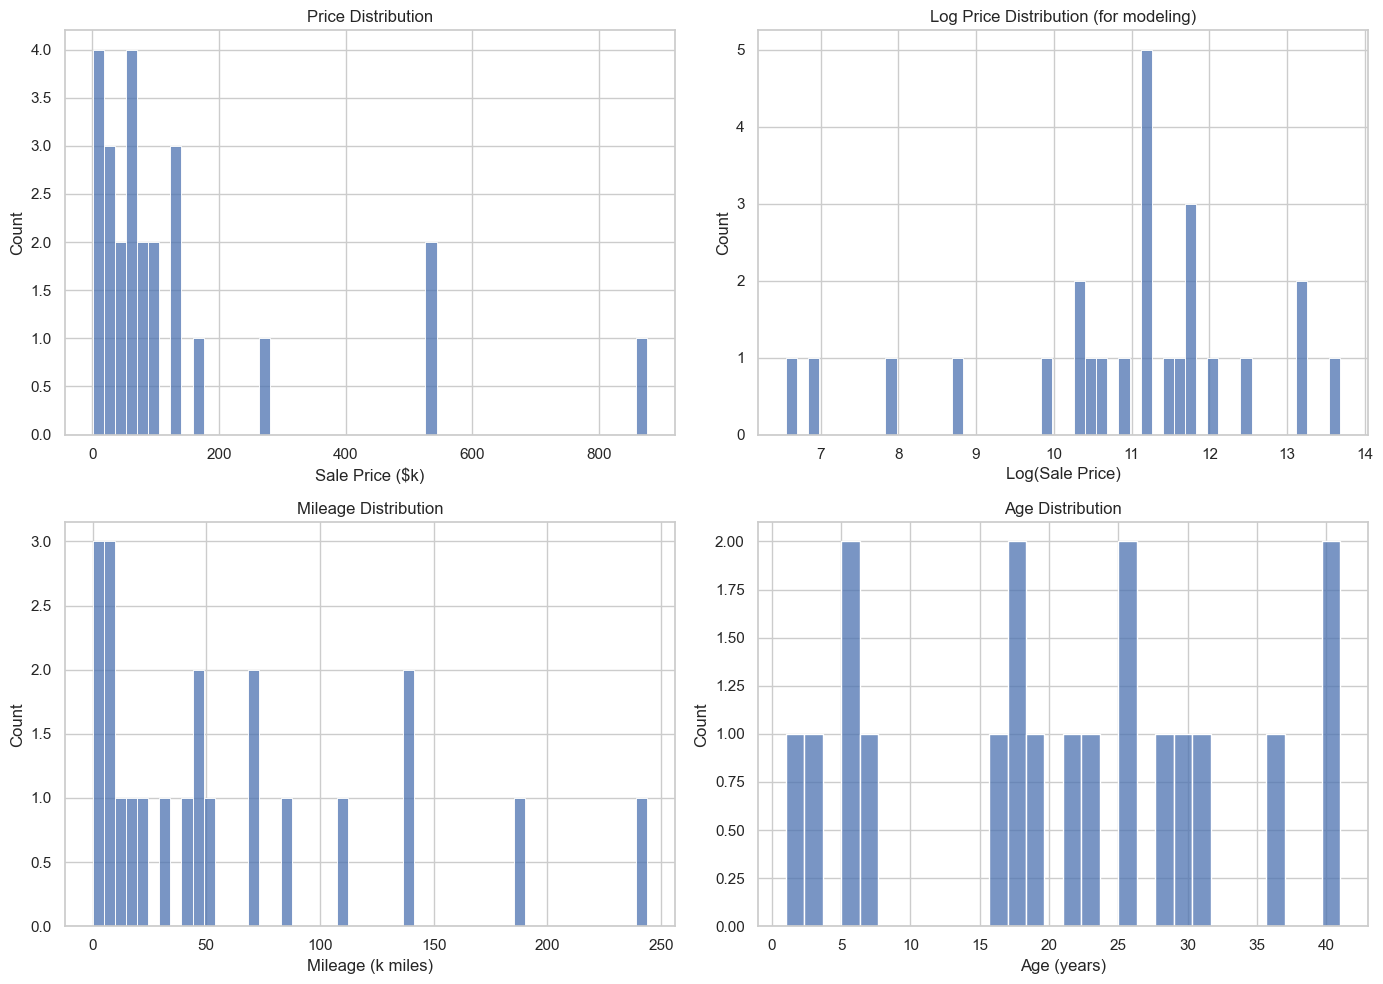

In [8]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Price distribution
sns.histplot(df["sale_price"].dropna() / 1000, bins=50, ax=axes[0, 0])
axes[0, 0].set_xlabel("Sale Price ($k)")
axes[0, 0].set_title("Price Distribution")

# Log price distribution
sns.histplot(df["log_price"].dropna(), bins=50, ax=axes[0, 1])
axes[0, 1].set_xlabel("Log(Sale Price)")
axes[0, 1].set_title("Log Price Distribution (for modeling)")

# Mileage distribution
sns.histplot(df["mileage"].dropna() / 1000, bins=50, ax=axes[1, 0])
axes[1, 0].set_xlabel("Mileage (k miles)")
axes[1, 0].set_title("Mileage Distribution")

# Age distribution
sns.histplot(df["age"].dropna(), bins=30, ax=axes[1, 1])
axes[1, 1].set_xlabel("Age (years)")
axes[1, 1].set_title("Age Distribution")

plt.tight_layout()
plt.show()

## Categorical Counts

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


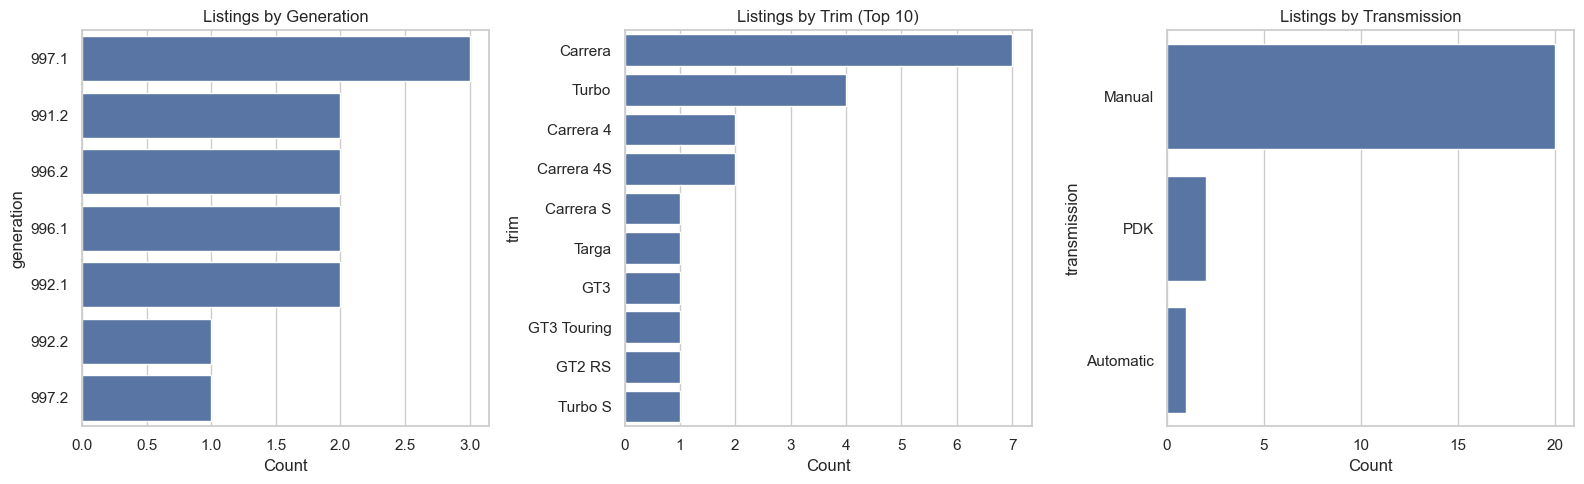

In [9]:
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

# Generation counts
gen_counts = df["generation"].value_counts()
sns.barplot(x=gen_counts.values, y=gen_counts.index, ax=axes[0], orient="h")
axes[0].set_title("Listings by Generation")
axes[0].set_xlabel("Count")

# Trim counts (top 10)
trim_counts = df["trim"].value_counts().head(10)
sns.barplot(x=trim_counts.values, y=trim_counts.index, ax=axes[1], orient="h")
axes[1].set_title("Listings by Trim (Top 10)")
axes[1].set_xlabel("Count")

# Transmission counts
trans_counts = df["transmission"].value_counts()
sns.barplot(x=trans_counts.values, y=trans_counts.index, ax=axes[2], orient="h")
axes[2].set_title("Listings by Transmission")
axes[2].set_xlabel("Count")

plt.tight_layout()
plt.show()

## Price by Model Year & Sale Date

In [ ]:
# Focus on key generations
key_gens = ["991.1", "991.2", "992.1", "997.1", "997.2", "996.1", "996.2"]
df_key = df[df["generation"].isin(key_gens)].copy()

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Price by model year (scatter)
ax = axes[0]
for gen in key_gens:
    subset = df_key[df_key["generation"] == gen]
    if len(subset) > 0:
        ax.scatter(
            subset["model_year"],
            subset["sale_price"] / 1000,
            label=gen,
            alpha=0.7,
            s=50,
        )
ax.set_xlabel("Model Year")
ax.set_ylabel("Sale Price ($k)")
ax.set_title("Price by Model Year")
ax.legend()

# Price over sale time (if enough data)
ax = axes[1]
has_data = False
for gen in key_gens:
    subset = df_key[df_key["generation"] == gen]
    if len(subset) >= 2:  # Need at least 2 points to show trend
        ax.scatter(
            subset["sale_date"],
            subset["sale_price"] / 1000,
            label=gen,
            alpha=0.7,
            s=50,
        )
        has_data = True

if has_data:
    ax.set_xlabel("Sale Date")
    ax.set_ylabel("Sale Price ($k)")
    ax.set_title("Price by Sale Date")
    ax.legend()
else:
    ax.text(0.5, 0.5, "Not enough data for time series", ha="center", va="center", transform=ax.transAxes)
    ax.set_title("Price by Sale Date (insufficient data)")

plt.tight_layout()
plt.show()

## Price by Mileage

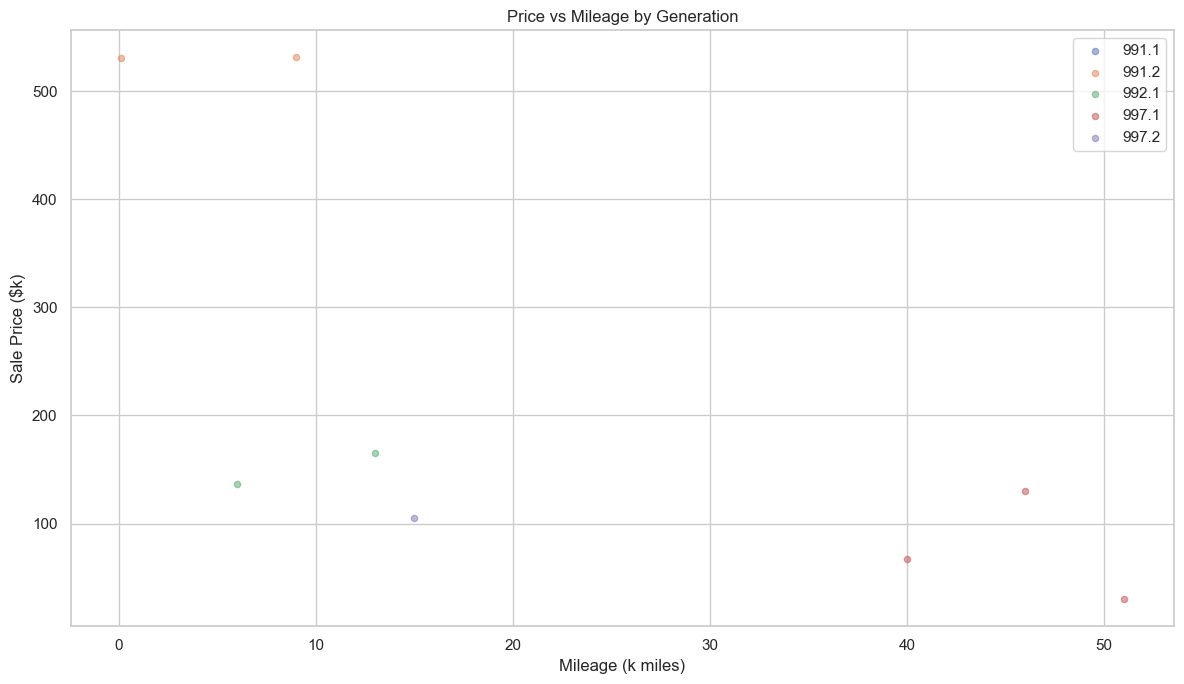

In [11]:
fig, ax = plt.subplots(figsize=(12, 7))
for gen in key_gens:
    subset = df_key[df_key["generation"] == gen]
    ax.scatter(
        subset["mileage"] / 1000,
        subset["sale_price"] / 1000,
        label=gen,
        alpha=0.5,
        s=20,
    )

ax.set_xlabel("Mileage (k miles)")
ax.set_ylabel("Sale Price ($k)")
ax.set_title("Price vs Mileage by Generation")
ax.legend()
plt.tight_layout()
plt.show()

## Manual vs PDK Premium

In [ ]:
# Compare manual vs PDK prices
# With small datasets, compare overall (not controlling for generation+trim)
trans_df = df[df["transmission"].isin(["Manual", "PDK"])].copy()

if len(trans_df) > 0:
    # Overall comparison
    print("=== Overall Manual vs PDK ===")
    overall = trans_df.groupby("transmission")["sale_price"].agg(["count", "median", "mean"])
    overall["median"] = overall["median"].apply(lambda x: f"${x:,.0f}")
    overall["mean"] = overall["mean"].apply(lambda x: f"${x:,.0f}")
    display(overall)

    # By generation (if enough data)
    print("\n=== By Generation (where both exist) ===")
    gen_trans = trans_df.groupby(["generation", "transmission"])["sale_price"].agg(["count", "median"])
    gen_trans_wide = gen_trans.unstack("transmission")
    # Only show where we have both Manual and PDK
    gen_trans_wide = gen_trans_wide.dropna()
    if len(gen_trans_wide) > 0:
        display(gen_trans_wide)
    else:
        print("Not enough data - need same generation with both Manual and PDK listings")
else:
    print("No Manual or PDK listings in dataset")

## Correlation Matrix

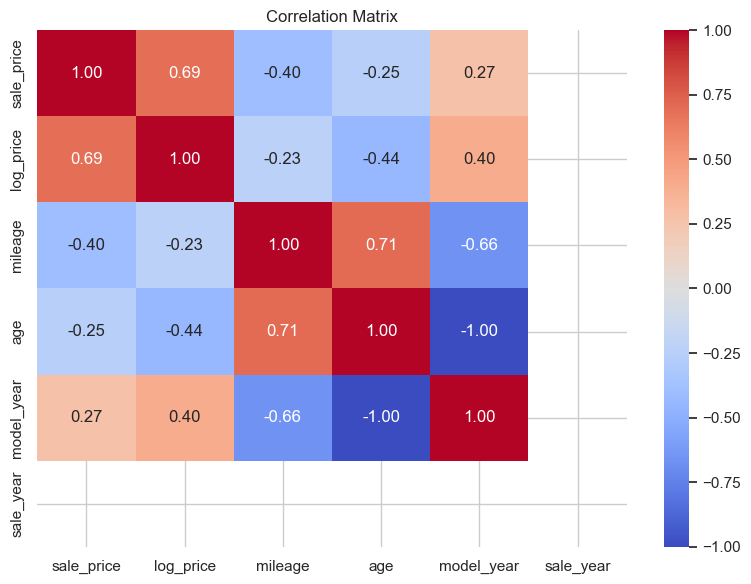

In [13]:
numeric_cols = ["sale_price", "log_price", "mileage", "age", "model_year", "sale_year"]
corr = df[numeric_cols].corr()

fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm", center=0, ax=ax)
ax.set_title("Correlation Matrix")
plt.tight_layout()
plt.show()

## Prepare Model-Ready Data

In [14]:
df_model = prepare_model_data(df)
print(f"Model-ready data: {len(df_model)} listings")
display(df_model.head())

INFO:price_analysis.data.cleaning:Model-ready dataset: 12 listings (from 25 cleaned)


Model-ready data: 12 listings


,listing_url,title_raw,sale_price,sale_date,model_year,generation,trim,transmission,mileage,color,location,sale_year,age,mileage_10k,mileage_scaled,color_category,log_price,is_valid
2,https://bringatrailer.com/listing/2007-porsche...,2007 Porsche 911 Carrera Cabriolet,30000,2025-12-23,2007,997.1,Carrera,Automatic,51000,Basalt Black Metallic,"Big Spring, Texas 79720",2025.0,18.0,5.1,-0.15186,standard,10.308953,True
3,https://bringatrailer.com/listing/2003-porsche...,2003 Porsche 911 Carrera Cabriolet 6-Speed,19851,2025-12-23,2003,996.2,Carrera,Manual,85000,Arctic Silver Metallic,"Watertown, New York 13601",2025.0,22.0,8.5,0.363762,standard,9.896010,True
4,https://bringatrailer.com/listing/1999-porsche...,LS3-Powered 1999 Porsche 911 Carrera 4 Coupe 6...,35911,2025-12-23,1999,996.1,Carrera 4,Manual,187000,Blue,"Fuquay Varina, North Carolina 27526-0138",2025.0,26.0,18.7,1.910629,standard,10.488799,True
6,https://bringatrailer.com/listing/2006-porsche...,40k-Mile 2006 Porsche 911 Carrera S Coupe 6-Speed,67500,2025-12-23,2006,997.1,Carrera S,Manual,40000,Black,"Neptune, New Jersey 07753",2025.0,19.0,4.0,-0.318679,standard,11.119883,True
9,https://bringatrailer.com/listing/2002-porsche...,2002 Porsche 911 Turbo Coupe 6-Speed,69000,2025-12-24,2002,996.2,Turbo,Manual,73000,Guards Red,"Frisco, Texas 75036",2025.0,23.0,7.3,0.181778,special,11.141862,True


In [15]:
# Save cleaned data
df.to_parquet(OUTPUT_PATH, index=False)
print(f"Saved cleaned data to {OUTPUT_PATH}")

Saved cleaned data to ../data/processed/cleaned_listings.parquet
